BIGRU Updated V1

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import shap
from lime.lime_text import LimeTextExplainer
import string

In [5]:
data = pd.read_csv('C:/Users/sachu/Desktop/DB/final_ats_scores9.csv')

# Basic data inspection
print(data.head())
print(data.info())


         ID                                         Resume_str    Category  \
0  27558837           STAFF ACCOUNTANT                 Expe...  ACCOUNTANT   
1  27558837           STAFF ACCOUNTANT                 Expe...  ACCOUNTANT   
2  27558837           STAFF ACCOUNTANT                 Expe...  ACCOUNTANT   
3  27558837           STAFF ACCOUNTANT                 Expe...  ACCOUNTANT   
4  27558837           STAFF ACCOUNTANT                 Expe...  ACCOUNTANT   

       job_id                                        title  \
0  3905367422                           Trademark Attorney   
1  3887888322  Delivery Driver / CDL A required / Seasonal   
2  3905243094                             Senior Recruiter   
3  3905323971                Order Fulfillment Coordinator   
4  3903830212       Medical Assistant Urgent Care Per Diem   

                                         description  ATS_Score  
0  Junior Trademark Associate\nOur client is a to...       20.0  
1  PBNA $25.75 / hour\n\nC

        text_length   word_count
count   7436.000000  7436.000000
mean    6048.768558   771.778644
std     1886.859520   247.858908
min     1400.000000   156.000000
25%     5228.000000   674.000000
50%     5909.000000   750.000000
75%     6993.000000   891.000000
max    11831.000000  1519.000000


c:\Users\sachu\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


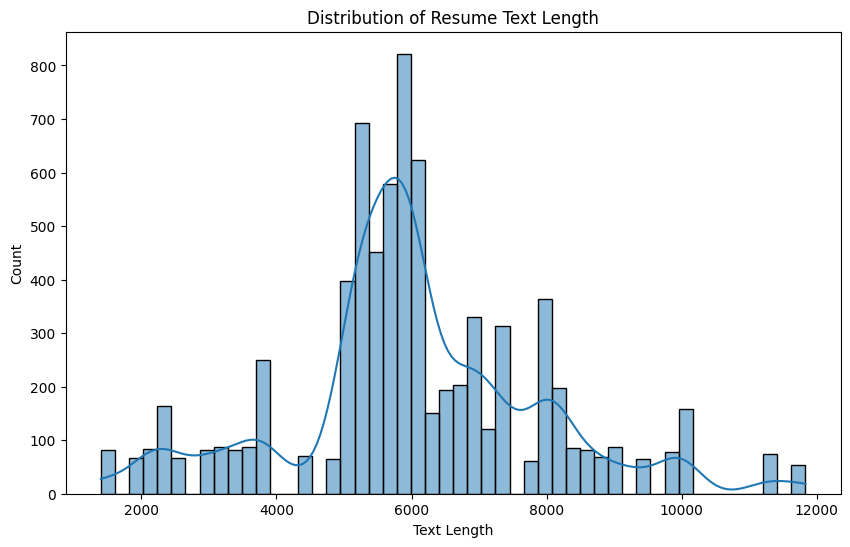

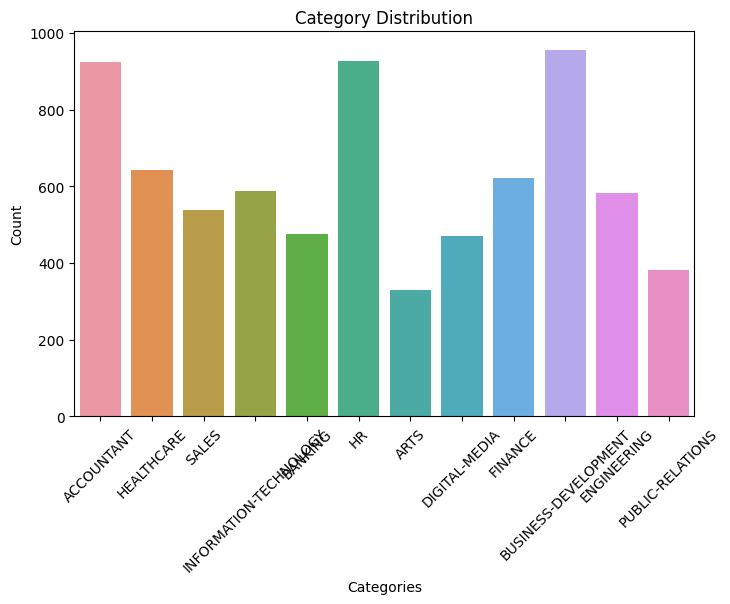

In [12]:
# Text Statistics
data['text_length'] = data['Resume_str'].apply(lambda x: len(str(x)))
data['word_count'] = data['Resume_str'].apply(lambda x: len(str(x).split()))
print(data[['text_length', 'word_count']].describe())

# Visualize text length distribution
plt.figure(figsize=(10, 6))
sns.histplot(data['text_length'], bins=50, kde=True)
plt.title('Distribution of Resume Text Length')
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.show()

# Class Distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='Category', data=data)
plt.title('Category Distribution')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Handle missing values if any
data.dropna(inplace=True)

# Encode categorical variables like 'Category'
encoder = LabelEncoder()
data['Category'] = encoder.fit_transform(data['Category'])

In [13]:


# Handle missing values if any
data.dropna(inplace=True)

# Encode categorical variables like 'Category'
encoder = LabelEncoder()
data['Category'] = encoder.fit_transform(data['Category'])

# Advanced text cleaning function
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    # Remove stopwords and lemmatize
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Apply cleaning to 'Resume_str' and 'description' columns
data['Cleaned_Resume'] = data['Resume_str'].apply(clean_text)
data['Cleaned_Description'] = data['description'].apply(clean_text)

In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


max_len = 4000

tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['Resume_str'] + ' ' + data['description'])

X_resume = tokenizer.texts_to_sequences(data['Resume_str'])
X_description = tokenizer.texts_to_sequences(data['description'])

X_resume_padded = pad_sequences(X_resume, maxlen=max_len)
X_description_padded = pad_sequences(X_description, maxlen=max_len)

import spacy

# Load the SpaCy model
nlp = spacy.load('en_core_web_sm')

# Function to extract nouns from text
def extract_nouns(text):
    doc = nlp(text)
    nouns = [token.text for token in doc if token.pos_ == 'NOUN']
    return nouns

# Example function to find matching nouns between resume and job description
def find_matching_nouns(resume, job_description):
    resume_nouns = set(extract_nouns(resume))
    job_description_nouns = set(extract_nouns(job_description))
    matching_nouns = resume_nouns.intersection(job_description_nouns)
    return len(matching_nouns)  # You can also return matching_nouns if you want to use them differently


data['matching_nouns'] = data.apply(lambda row: find_matching_nouns(row['Resume_str'], row['description']), axis=1)


X_combined = np.concatenate([X_resume_padded, X_description_padded], axis=-1)

y = data['ATS_Score'].values



In [17]:
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [18]:
vocab_size = len(tokenizer.word_index) + 1

In [20]:
from keras.layers import Input, Embedding, Bidirectional, GRU, Dense, Dropout, BatchNormalization, GlobalAveragePooling1D
from keras.models import Model
from keras.optimizers import Adam
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Bidirectional, GRU, Dropout
from tensorflow.keras.metrics import AUC
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input,Embedding, Bidirectional, GRU, Dropout, Dense, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [21]:
from keras.layers import Concatenate
max_len = 4000  # Adjust based on your data preprocessing
vocab_size = 20000  
embedding_dim = 100
units_1 = 32  # Reduced from 64
dense_units = 32  # Reduced from 64
learning_rate = 1e-3
l2_reg = 1e-4

def build_gru_model_with_noun_feature():
    # Input layers
    input_seq = Input(shape=(2 * max_len,), dtype='int32')
    input_nouns = Input(shape=(1,), dtype='float32')

    # Embedding layer
    x = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=2 * max_len)(input_seq)

    # GRU Layer
    gru_output = Bidirectional(GRU(units_1, return_sequences=False, dropout=0.3, recurrent_dropout=0.3))(x)

    # Concatenate GRU output with the noun feature
    concatenated = Concatenate()([gru_output, input_nouns])

    # Dense Layer
    x = Dense(dense_units, activation='relu')(concatenated)
    x = Dropout(0.5)(x)

    # Output Layer
    output = Dense(1, activation='linear')(x)  # Use 'linear' for regression tasks

    model = Model(inputs=[input_seq, input_nouns], outputs=output)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error', metrics=['mae'])

    return model

# Build the modified model
model_with_noun_feature = build_gru_model_with_noun_feature()


c:\Users\sachu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [22]:
# Example data preparation (replace with actual data)
# X_combined = np.concatenate([X_resume, X_description], axis=-1)
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Ensure the combined data has the correct shape
if X_combined.shape[1] == 2 * max_len:
    X_combined_reshaped = X_combined  # No need to reshape if already in correct shape
else:
    raise ValueError(f"The shape of X_combined is {X_combined.shape}, which cannot be reshaped to (X_combined.shape[0], {2 * max_len}).")

# Prepare the noun feature
X_nouns = data['matching_nouns'].values.reshape(-1, 1)

# Split data into training, validation, and test sets
X_train, X_test, X_train_nouns, X_test_nouns, y_train, y_test = train_test_split(X_combined_reshaped, X_nouns, y, test_size=0.2, random_state=42)
X_train, X_val, X_train_nouns, X_val_nouns, y_train, y_val = train_test_split(X_train, X_train_nouns, y_train, test_size=0.2, random_state=42)
# Define callbacks for early stopping, learning rate reduction, and checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Training the modified model
history = model_with_noun_feature.fit(
    [X_train, X_train_nouns], y_train,
    epochs=10,  # Example value, can be adjusted
    batch_size=64,  # Example value, can be adjusted
    validation_data=([X_val, X_val_nouns], y_val),
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

# Evaluate the model on the test set
test_loss, test_mae = model_with_noun_feature.evaluate([X_test, X_test_nouns], y_test)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")


Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1937s 26s/step - loss: 2577.8403 - mae: 47.4816 - val_loss: 2560.8889 - val_mae: 47.7140 - learning_rate: 0.0010
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2428s 32s/step - loss: 2565.0818 - mae: 47.4375 - val_loss: 2553.7441 - val_mae: 47.6424 - learning_rate: 0.0010
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2668s 36s/step - loss: 2558.9038 - mae: 47.3545 - val_loss: 2546.6243 - val_mae: 47.5709 - learning_rate: 0.0010
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2645s 35s/step - loss: 2583.9824 - mae: 47.5598 - val_loss: 2539.5210 - val_mae: 47.4994 - learning_rate: 0.0010
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2681s 36s/step - loss: 2547.7483 - mae: 47.1497 - val_loss: 2532.4370 - val_mae: 47.4280 - learning_rate: 0.0010
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2864s 38s/step - loss: 2515.8542 - mae: 46.8400 - val_loss: 2525.3743 - val_mae: 47.3567 - learning_rate: 0.0010
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 3091s 41s/step - loss: 2503.6870 - mae: 46.7559 - val_lo

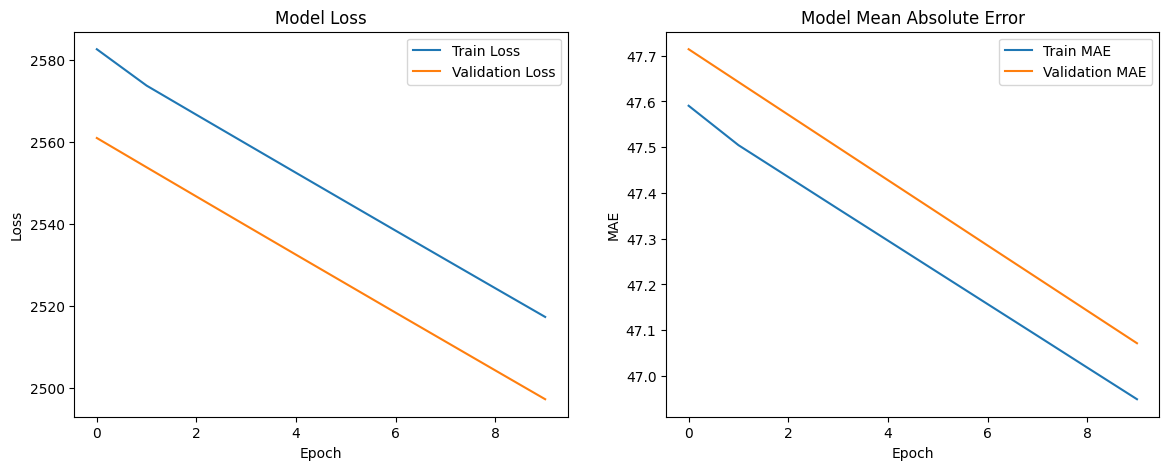

In [23]:
# Evaluate the model on the test set
# test_loss, test_mae =model_with_noun_feature.evaluate(X_test, y_test)

# print(f"Test Loss: {test_loss}")
# print(f"Test MAE: {test_mae}")
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation MAE values
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.show()


In [24]:
# Save the model
model_with_noun_feature.save('bigru_model_n.h5')
model_with_noun_feature.save('bigru_model_n.keras')

In [25]:
import numpy as np
import shap
from tensorflow import keras
import gc

# Load the model
model = keras.models.load_model('bigru_model_n.keras')

# Assuming X_train_seq is your training data
X_train_seq = np.array(X_train)

# Reshape or pad X_train_seq to (n_samples, 4000)
if X_train_seq.shape[1] < 4000:
    padding = np.zeros((X_train_seq.shape[0], 4000 - X_train_seq.shape[1]))
    X_train_seq = np.concatenate((X_train_seq, padding), axis=1)
elif X_train_seq.shape[1] > 4000:
    X_train_seq = X_train_seq[:, :4000]

# Sample background data to reduce the size
K = 50  # Further reduced background sample size
background_data = shap.sample(X_train_seq, K)

# Use DeepExplainer instead of KernelExplainer
explainer = shap.DeepExplainer('bigru_model_n.keras', background_data)

# Calculate SHAP values for the training data in smaller batches
batch_size = 5  # Smaller batch size
shap_values = []

for i in range(0, X_train_seq.shape[0], batch_size):
    batch = X_train_seq[i:i + batch_size]
    shap_values_batch = explainer.shap_values(batch)
    shap_values.append(shap_values_batch)
    gc.collect()  # Free up memory after each batch

# Concatenate the SHAP values from all batches
shap_values = np.concatenate(shap_values, axis=0)

# Visualize the SHAP values for the first instance
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X_train_seq[0])


c:\Users\sachu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 13 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
c:\Users\sachu\AppData\Local\Programs\Python\Python311\Lib\site-packages\shap\explainers\_deep\deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


ValueError: <class 'str'> is not currently a supported model type!